In [24]:
#LETKF-random
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv



def L96(Xa,F):
    
    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb
def Forecast(Xa,m):
    h = 0.05 
    F = 8.0
    
    
    Xf = np.zeros((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    dXf = Xf - Xf_.reshape(-1,1)
    #print(dXf)
    Pf = dXf @ dXf.T/(m-1)
    #Pf = Pf*L
    
    return Xf,Pf,dXf,Xf_

def Analysis(dXf,Xf_,y,m,a,loc,rho,sigma):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(m)

    obs=np.arange(N)
    obs=np.delete(obs,loc)
    D = np.zeros((N,p))
    for s in range(N):
        for u in range(p):
            D[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
    #print(obs)
    Xa = np.zeros((N,m))
    Xa_ = np.zeros(N)
    dXa = np.zeros((N,m))
    #使う値は前後10点に限定
    for i in range(N):
        d = D[i]
        far = np.arange(p)
        far = far[d>2*np.sqrt(10/3)*sigma]
        yi = y
        Hi = H
        Ri = R
        yi = np.delete(yi,far)
        Hi = np.delete(Hi,far,axis=0)
        Ri = np.delete(Ri,far,axis=0)
        Ri = np.delete(Ri,far,axis=1)
        #print(yi.shape,Hi.shape,Ri.shape)
        diagR = np.diag(Ri)
        di = yi - Hi @ Xf_
        dYi = Hi @ dXf
        L = np.exp(-d**2/(2*sigma**2))
        L = np.delete(L,far)
        Ri = np.diag(diagR/L)
        R_inv = np.linalg.inv(Ri)
    
        A = (m-1)*I/rho + dYi.T @ R_inv @ dYi
        la,v = np.linalg.eigh(A) #eigenvalue decomposition
        D_inv = np.linalg.inv(np.diag(la))
        U = np.array(v).reshape(m,m)
        Pa_ = U @ D_inv @ U.T #UD^(-1)UT
        #print(Pa_)
    
        Xa_[i] = Xf_[i] + dXf[i,:] @ Pa_ @ dYi.T @ R_inv @ di 
        Pa_root = U @ np.sqrt(D_inv) @ U.T
        Pa_root = Pa_root * np.sqrt(m-1)
        dXa[i,:] = dXf[i,:] @ Pa_root
        Xa[i,:] = np.full(m,Xa_[i]) + dXa[i,:]
            
    #print("Xa_",Xa_)
    #print("dXa",dXa)
    #print("Xa",Xa)
    Pa = dXa @ dXa.T/(m-1)
    
    return Xa,Pa,Xa_

7.5 1.1


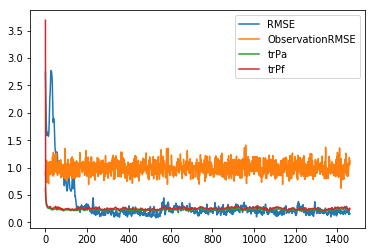

0.21560863351351106


In [25]:

t = 1460
N = 40
m = 10
h = 0.05 
F = 8.0
#初期値
Xa = np.zeros((N,m))
Xc = np.random.rand(N,m)
for j in range(500):
    Xb = Rungekutta4(Xc,h,F)
    Xc = Xb
Xa = Xb
#plt.plot(Xa[:,9])
#plt.plot(Xa[:,8])
#plt.show()

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
A = []
B = []
for i in range(1):
    a = 0
    sigma = 7.5
    for j in range(1):
        rho = 1.1
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        for k in range(t):
            loc = np.random.choice(N,a,replace=False)
            loc.sort() 
            y = np.delete(Y[k],loc)
            
            (Xf,Pf,dXf,Xf_) = Forecast(Xa,m)
            (Xa,Pa,Xa_) = Analysis(dXf,Xf_,y,m,a,loc,rho,sigma)
            #print(Xf)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k,:]
            Y1 = Y[k,:]
            rmse = np.sum((Xa-X1.reshape(-1,1))**2)
            rmsef = np.sum((Xf-X1.reshape(-1,1))**2)
            rmse_ = np.sum((Xa_-X1)*(Xa_-X1)) 
            rmseo = np.sum((Y1-X1)*(Y1-X1))
            rmse = np.sqrt(rmse/N)
            rmsef = np.sqrt(rmsef/N)
            rmse_ = np.sqrt(rmse_/N)
            rmseo = np.sqrt(rmseo/N)
            err = 0
            err2 = 0
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
             #   print(k)
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A.append(sigma)
        B.append(rho)
        print(sigma,rho)
#print(trPa)
#print(R)
#plt.plot(A,RMSE,label="RMSE")
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
#plt.xlabel("observation missing")
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
plt.savefig("LETKF.jpg")
plt.show()
print(np.mean(R_[500:]))
#df = pd.DataFrame(RMSE)
#df.to_csv("LETKF.csv")

In [1]:
#BV dimension

def Forecast_BV(Xa,window_size):
    h = 0.05
    F = 8.0
    
    X1 = Xa
    
    for k in range(window_size):
        Xf = Rungekutta4(X1,h,F)
        X1 = Xf
       
    return Xf

def get_BV(m,alpha,window_size):
    t = 500
    N = 40
    h = 0.05 
    F = 8.0

    P = []
    Pt2 = []
    P2 = []
    errcov = []

    BVs=[]
    #a_list=[0.5,1.0,5.0]
    #alpha=0.5 #rescaling
    
    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
        #B = np.eye(N) * 0.2
    #Xa = np.ones(N)*F
    #print(Xa)
    #print(B)

#for window_size in [4]:
    #window_size=4 #assimilation window length
    t = t*window_size
    print(alpha,window_size)
    BV=[]
    dX_norm=np.zeros(m)
    BVdim=[]

    #初期摂動
    dX = np.random.rand(m,N)
    #dX_norm = np.linalg.norm(dX)
    dX_norm = np.sqrt(np.sum(dX*dX,axis=1,keepdims=True)/N)
    dX = dX/dX_norm
    dX_norm = np.sqrt(np.sum(dX*dX,axis=1,keepdims=True)/N)
    #print(dX_norm)
    #for i in range(1,5):
    #    for j in range(i):
    #        dX[i] -= dX[j]
    Q,R = np.linalg.qr(dX.T)
    dX = Q.T
    dX_norm = np.sqrt(np.sum(dX*dX,axis=1,keepdims=True)/N)
    dX = dX*alpha/dX_norm
    dX_norm = np.sqrt(np.sum(dX*dX,axis=1,keepdims=True)/N)
    #print(dX,dX_norm)
    #BV.append(dX[0])

    X1 = dX
    
    C = dX@dX.T
    #print(C.shape)
    la,v = np.linalg.eig(C)
    #print(la)
    dim = (sum(la))**2/sum(la**2)
    print(dim)
    BVdim.append(dim)
    #plt.plot(dX)
    
    X=[]
    X.append(X0)
    for k in range(t):    
        Xf = Rungekutta4(Xa,h,F)
        Xa = Xf
        X.append(Xf)
    
    t=int(t/window_size)
    #print(t)
    Xa_=np.zeros((m,N))
    Xf_=Xa_
    for i in range(m):
        Xa_[i]=X0+X1[i]
        #print(Xa_)
    breed_num=0
    for k in range(t):
        for i in range(m):
            Xf_[i] = Forecast_BV(Xa_[i],window_size)
    
            dXa = Xf_[i]-X[k*window_size]
                #new_norm = np.linalg.norm(dXa)
            new_norm = np.sqrt(sum(dXa*dXa)/N)
            if(new_norm>dX_norm[i]):
                dXa = dXa*alpha/new_norm
            
            dX[i] = dXa
                #dX_norm=np.linalg.norm(dX)
            dX_norm[i]=np.sqrt(sum(dX[i]*dX[i])/N)
                #print(dX_norm)
            Xa_[i]= X[k*window_size]+dX[i]
        breed_num+=1
            #print(dX)
        #Ortho-normalization
        Q,R = np.linalg.qr(dX.T)
        dX = Q.T
        BV.append([dX[i] for i in range(m)])
        C = dX@dX.T
            #print(C.shape)
        la,v = np.linalg.eig(C)
            #print(la)
        dim = (sum(la))**2/sum(la**2) 
        if(dim-1<0.0001):
            break
        BVdim.append(dim)
        if(k%100==0):
            print(k)            
            plt.plot(dX[0])
            plt.show()
    print('end',breed_num)
    Xbar = X[k*window_size]
    plt.plot(BVdim)
    plt.title("BV dimension")
    plt.show()
    """xs=np.arange(N*5)
    time=np.arange(100)
    BV = np.array(BV).reshape(breed_num,N*5)
    plt.pcolor(xs,time,BV[-100:,:],cmap='RdBu_r')
    plt.colorbar()
    plt.xlabel('site')
        #plt.ylabel('breeding time')
    plt.show()"""
    for l in range(m):
        plt.plot(dX[l])
    plt.show()
    #print(l,Bnorm[l])
        #dX = np.array(BV[l])
    s=np.argmax(la)
    print(s)
    BVs.append(dX)
    
    return BVs,Xbar
    #dXs=np.array(BVs).reshape(-1,N)
    #print(dXs.shape)

In [2]:
#LETKF-BV
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv



def L96(Xa,F):
    
    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb
def Forecast(Xa,m):
    h = 0.05 
    F = 8.0
    
    
    Xf = np.zeros((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    dXf = Xf - Xf_.reshape(-1,1)
    #print(dXf)
    Pf = dXf @ dXf.T/(m-1)
    #Pf = Pf*L
    
    return Xf,Pf,dXf,Xf_

def Analysis(dXf,Xf_,y,m,a,loc,rho,sigma):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(m)

    obs=np.arange(N)
    obs=np.delete(obs,loc)
    D = np.zeros((N,p))
    for s in range(N):
        for u in range(p):
            D[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
    #print(obs)
    Xa = np.zeros((N,m))
    Xa_ = np.zeros(N)
    dXa = np.zeros((N,m))
    #使う値は前後10点に限定
    for i in range(N):
        d = D[i]
        far = np.arange(p)
        far = far[d>2*np.sqrt(10/3)*sigma]
        yi = y
        Hi = H
        Ri = R
        yi = np.delete(yi,far)
        Hi = np.delete(Hi,far,axis=0)
        Ri = np.delete(Ri,far,axis=0)
        Ri = np.delete(Ri,far,axis=1)
        #print(yi.shape,Hi.shape,Ri.shape)
        diagR = np.diag(Ri)
        di = yi - Hi @ Xf_
        dYi = Hi @ dXf
        L = np.exp(-d**2/(2*sigma**2))
        L = np.delete(L,far)
        Ri = np.diag(diagR/L)
        R_inv = np.linalg.inv(Ri)
    
        A = (m-1)*I/rho + dYi.T @ R_inv @ dYi
        la,v = np.linalg.eigh(A) #eigenvalue decomposition
        D_inv = np.linalg.inv(np.diag(la))
        U = np.array(v).reshape(m,m)
        Pa_ = U @ D_inv @ U.T #UD^(-1)UT
        #print(Pa_)
    
        Xa_[i] = Xf_[i] + dXf[i,:] @ Pa_ @ dYi.T @ R_inv @ di 
        Pa_root = U @ np.sqrt(D_inv) @ U.T
        Pa_root = Pa_root * np.sqrt(m-1)
        dXa[i,:] = dXf[i,:] @ Pa_root
        Xa[i,:] = np.full(m,Xa_[i]) + dXa[i,:]
            
    #print("Xa_",Xa_)
    #print("dXa",dXa)
    #print("Xa",Xa)
    Pa = dXa @ dXa.T/(m-1)
    
    return Xa,Pa,Xa_

1.0 4
5.0
0


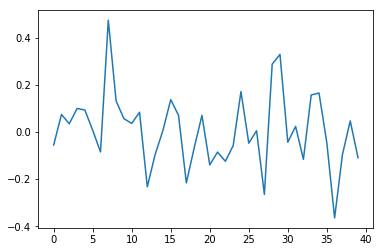

100


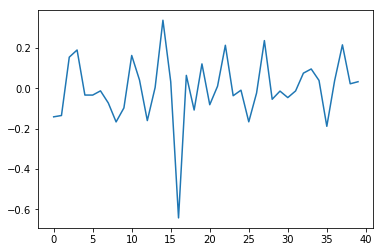

200


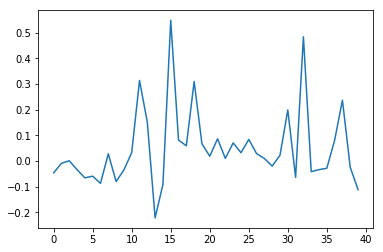

300


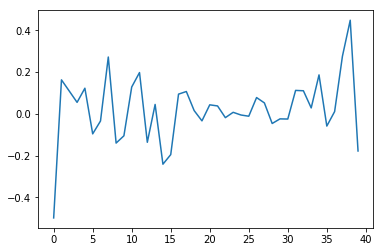

400


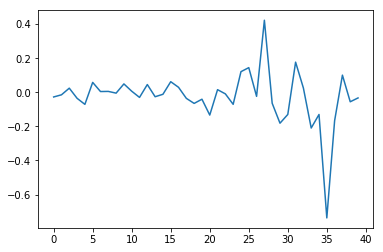

end 500


C:\Users\saori\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


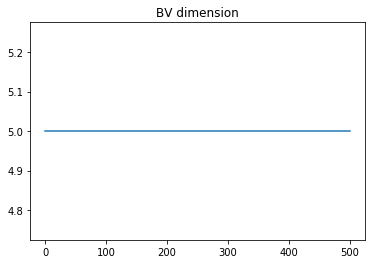

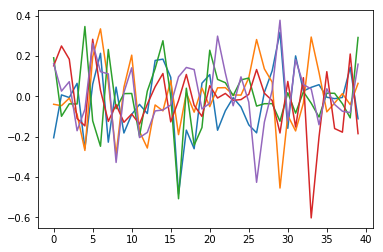

1
(5, 40)
(40, 10)
(40, 10)
7.5 1.1


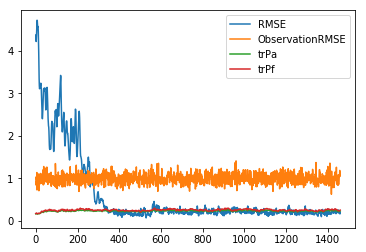

0.2103574422073583


In [7]:

t = 1460
N = 40
m = 10
h = 0.05 
F = 8.0
#初期値
Xa = np.zeros((N,m))
Xc = np.random.rand(N)
for j in range(500):
    Xb = Rungekutta4(Xc,h,F)
    Xc = Xb
BVs,X0 = get_BV(int(m/2),1.0,4)
dX = np.array(BVs).reshape(-1,N)
print(dX.shape)
dX0 = np.concatenate([dX,-dX])
dX0 = dX0.T
print(dX0.shape)

Xa = Xc.reshape(-1,1)+dX0
print(Xa.shape)
#plt.plot(Xa[:,9])
#plt.plot(Xa[:,8])
#plt.show()

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
A = []
B = []
for i in range(1):
    a = 0
    sigma = 7.5
    for j in range(1):
        rho = 1.1
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        for k in range(t):
            loc = np.random.choice(N,a,replace=False)
            loc.sort() 
            y = np.delete(Y[k],loc)
            
            (Xf,Pf,dXf,Xf_) = Forecast(Xa,m)
            (Xa,Pa,Xa_) = Analysis(dXf,Xf_,y,m,a,loc,rho,sigma)
            #print(Xf)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k,:]
            Y1 = Y[k,:]
            rmse = np.sum((Xa-X1.reshape(-1,1))**2)
            rmsef = np.sum((Xf-X1.reshape(-1,1))**2)
            rmse_ = np.sum((Xa_-X1)*(Xa_-X1)) 
            rmseo = np.sum((Y1-X1)*(Y1-X1))
            rmse = np.sqrt(rmse/N)
            rmsef = np.sqrt(rmsef/N)
            rmse_ = np.sqrt(rmse_/N)
            rmseo = np.sqrt(rmseo/N)
            err = 0
            err2 = 0
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
             #   print(k)
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A.append(sigma)
        B.append(rho)
        print(sigma,rho)
#print(trPa)
#print(R)
#plt.plot(A,RMSE,label="RMSE")
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
#plt.xlabel("observation missing")
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
plt.savefig("LETKF_BV.jpg")
plt.show()
print(np.mean(R_[500:]))
#df = pd.DataFrame(RMSE)
#df.to_csv("LETKF.csv")